In [1]:
!pwd

/Users/admin/SERVER2/BD_Scripts/ipython/notebooks/reference


In [32]:
import numpy as np
from re import findall as re_find
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(map(lambda x: round(x)-1, result), dtype=np.uint64)

In [5]:
!loggen --rate 10000 --size 8000 --interval 2 --inet 192.168.3.50 9200 --syslog-proto --sdata "[test  HOST=\"test\"]"

Send error Connection reset by peer, results may be skewed.
average rate = 13373.17 msg/sec, count=94, time=0.007, (average) msg size=8005, bandwidth=104482.96 kB/sec


In [144]:
unix_sock=''
port='12402'
tcp_addr='192.168.3.52 %s'%port
udp_addr=''
active_connection=1
idle_connections=0
msg_interval=2 # seconds
rate_range=r_min,r_max=[10,1000000] # msgs per second
size_range=s_min,s_max=[150,8000]
connection_types=[{'unix_stream':'--stream --unix %s'%unix_sock},
                  {'tcp_stream':'--stream --inet %s'%tcp_addr},
                  {'unix_dgram':'--dgram --unix %s'%unix_sock},
                  {'udp_dgram':'--dgram --inet %s'%udp_addr}]
# Other Options: ipv6, number of messages, read sdata from file, system protocol, ssl

# first run - 15x15 in log space
units=15

# Setup Result Table:
from datetime import datetime as DT
cols = ['rate_goal','size','average_rate (msg/sec)','bandwidth (kB/sec)']
df = pd.DataFrame(columns=cols)

# Setup Client:
!ssh mbp2 'nc -lk %s'%port

# RUN TEST:
start=DT.now()
print DT.strftime(start,'%Y.%m.%d - %H:%M:%S')

rate_iter = gen_log_space(r_max-r_min,15) + r_min
size_iter = gen_log_space(s_max-s_min,15) + s_min
pt_r,pt_s,done=0,0,False

while done==False:
    try:
        for r in rate_iter[pt_r:]:
            for s in size_iter[pt_s:]:
                _s=str(int(s))
                _r=str(int(r))
                t=!loggen --rate $_r --size $_s --interval $msg_interval --inet $tcp_addr
                x=','.join(t).split(',')
                try:
                    ave_rate=float('.'.join(re_find(r'\d+',x[11])))
                    bw=float('.'.join(re_find(r'\d+',x[12])))
                except:
                    ave_rate=float('.'.join(re_find(r'\d+',x[9])))
                    bw=float('.'.join(re_find(r'\d+',x[10])))
                df=df.append(dict(zip(cols,[_r,_s,ave_rate,bw])),ignore_index=True)
        done=True
        break
    except:
        pt_r,pt_s = rate_iter.astype(int).tolist().index(r),size_iter.astype(int).tolist().index(s)

end=DT.now()
print DT.strftime(end,'%Y.%m.%d - %H:%M:%S')

2015.01.02 - 20:59:30


In [152]:
rate_iter

array([    10,     12,     16,     28,     61,    148,    382,   1009,
         2692,   7206,  19316,  51803, 138957, 372765, 999999], dtype=uint64)

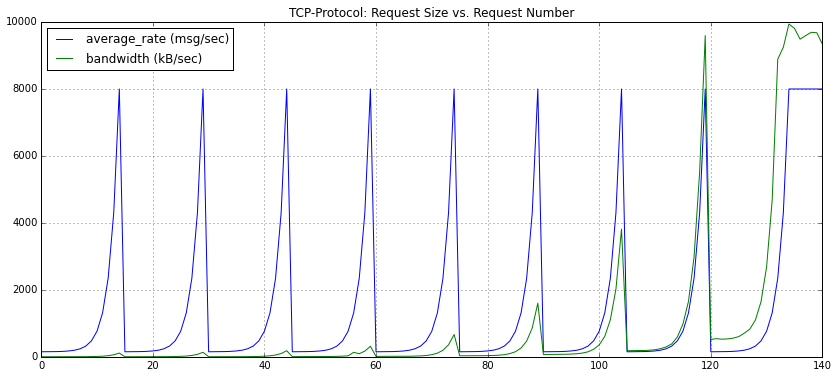

In [179]:
df.plot(figsize=(14,6),
        title='TCP-Protocol: Request Size vs. Request Number',legend=True)

In [148]:
%matplotlib inline

In [10]:
from IPython.display import FileLinks
FileLinks('./files/socat')

./files/socat/
  ._linuxwochen2007-socat.pdf
  linuxwochen2007-socat.pdf

In [15]:
from IPython.display import HTML
h=HTML('https://192.168.3.51:8901/notebooks/ipython/notebooks/reference/files/socat/linuxwochen2007-socat.pdf'); h

<IPython.core.display.HTML object>

### Socat

#####Forwarding Internal Logs

(A) below reads a file (source) into a unix socket (target); 

- `u` means only read target and only write source; 
- `lmuser` means log messages as 'user' facility in mixed way b/t sterr and syslog;
- `nonblock` really only applies to opening file but still important;
- `ignoreeof` (EOF=end of file) means the connection will stay open without continuous updates;
- `shut-null` means the source will cue the target of an EOF condition;
- `seek-end` true means the file read start at the current location as opposed to the beginning;
- `crnl` standardizes line terminations;
- `null-eof` means the target is sensitive to a source's EOF condition.

    (A) 
    
        sudo socat -d -d -lmuser -u \
        FILE:/var/log/syslog/syslog-ng.log,nonblock=1,ignoreeof,seek-end=1,shut-null \
        UNIX:/var/sockets/syslog-ng.sock,crnl,ignoreeof,null-eof

    Note:  (A) will fail if the socket (/var/sockets/syslog-ng.sock) does not exist, which is only true when an active process is listening on that channel.

    the syslog-ng daemon should be active and listening.
    or:

        sudo socat -d -d unix-listen:/var/sockets/syslog-ng.sock,reuseaddr -

    Test with:  

        syslog -s -l error -k Message "test msg"

##Debug Utils:

	nc serverip 1234
	
	/t2
	echo 'check error-to-tcp' | socat - UNIX-CLIENT:/var/sockets/ngx_error.sock
	echo 'check access-to-tcp' | socat - UNIX-CLIENT:/var/sockets/ngx_access.sock
	echo 'check logger-to-tcp' | socat - UNIX-CLIENT:/var/sockets/ngx_logger.sock
	
	echo 'just log message will be passed'
	
	syslog -s -l error -k Message "msg to syslog"

####Working Socket Tests:

From mbp2 to ubuntu

	[mbp2]		socat -v -u - TCP:192.168.3.55:12204
	[ubuntu]	socat -v tcp-l:12205,fork exec:'/bin/cat'

	[mbp2]		socat -v -u UNIX:/var/run/mbp2_relay.sock -
	
Not Sure:

    socat -d -d -d -d -v -U -,ignoreeof,shut-null unix:/var/sockets/web_socket_relay.sock,ignoreeof,forever,null-eof
    
Not Working:
	
    socat -v -u - UNIX:/var/run/asl_input
	
	socat -v -u UNIX:/dev/klog
	socat -v -u UNIX:/dev/klog
	socat -v -u UNIX-CONNECT:/var/run/syslog -
	
	socat -v -u SOCKET-DATAGRAM:/var/sockets/ngx_access_out.sock -

    
	socat -v -u UNIX-CONNECT:/var/run/syslog -
	socat -v -u UNIX-CLIENT:/var/run/syslog -
	socat -v UNIX-CONNECT:/dev/klog -
	socat -v UNIX-CONNECT:/var/run/syslog -
	socat -v PIPE:/dev/klog -
	sudo socat -v -u PIPE:/dev/klog -
	sudo socat -v -u PIPE:/dev/klog,fork exec:'/bin/cat'
	socat -v -u SOCKET-DATAGRAM:/var/run/syslog -
	socat -v -u SOCKET-LISTEN:/var/run/syslog -
	
	socat -v tcp-l:12205,fork UNIX:/var/sockets/ngx_logger.sock
	
	sudo socat -t100 -x -v UNIX-LISTEN:/var/run/syslog,mode=777,reuseaddr,fork UNIX-CONNECT:/var/run/syslog.original
    
    socat -u TCP-LISTEN:localhost:2866/ClipToOneNote,reuseaddr,fork OPEN:/tmp/onenote.clipper,creat,append
    
    socat -u udp-recv:1234 -
    socat -d -d TCP4-RECVFROM:2866,so-broadcast,so-timestamp,ip-pktinfo,ip-recverr,ip-recvopts,ip-recvtos,ip-recvttl!!- SYSTEM:'export; sleep 1' |grep SOCAT
    
    socat -d -d - tcp:localhost2866/ClipToOneNote,crnl

#### Changes to Make


	sudo socat TCP-LISTEN:80 -
	socat TCP-LISTEN:12204 -
	
	echo 'check logger-to-tcp' | sudo socat - TCP-LISTEN:80
	
	nc log.aporodelivery.com 1234
	
	socat -v tcp-l:12204,fork exec:'/bin/cat'
	socat -v tcp-l:192.168.3.55:12405,fork exec:'/bin/cat'
	
	echo 'check tcp-to-ngx' | socat - UNIX-CLIENT:"/69.22.228.27:12204"
	socat - UNIX-CLIENT:"/69.22.228.27:12204"
	socat - UNIX-CLIENT:192.168.3.52:12204

    sudo socat -t100 -v -u UNIX-RECVFROM:/var/run/syslog,mode=666,reuseaddr,fork UNIX-SENDTO:/var/run/syslog.original,fork -
	
	http://linux.die.net/man/1/nc

#FAILED CONFIGURATION #1:

##Logging Config @ MBP2

###NGINX:

#####nginx.conf
    
    error_log                       syslog:server=unix:/var/sockets/ngx_error_out.sock info;

###SYSLOG-NG:

#####osx logs:

    source:                         /var/log/syslog/syslog-ng.log
    destination:                    /var/sockets/osx_syslog_sock

#####nginx logs:

    source:                         /var/sockets/ngx_error_out.sock
    source:                         /var/sockets/ngx_access_out.sock
    source:                         /var/sockets/ngx_logger_out.sock
    destination:                    /var/sockets/osx_ngx_sock

###SOCAT:

#####Forward osx_syslog_sock to Ubuntu:

    socat -d -d -lmlocal2 UNIX-LISTEN:/var/sockets/osx_syslog_sock,fork,forever TCP4:192.168.3.55:12205,ignoreeof &
    
#####Forward osx_ngx_sock to Ubuntu:

    socat -d -d -lmlocal2 UNIX-LISTEN:/var/sockets/osx_ngx_sock,fork,forever TCP4:192.168.3.55:12205,ignoreeof &

##Logging Config @ UBUNTU

###NGINX:

#####nginx.conf
    
    error_log                       syslog:server=unix:/var/sockets/ngx_error.sock info;

#####run_json_decoder.conf

    access_log                      syslog:server=unix:/var/sockets/ngx_access.sock info;
    logger_out                      syslog:server=unix:/var/sockets/ngx_logger.sock info;

###SYSLOG-NG:

#####nginx logs:

    source:                         /var/sockets/ngx_error.sock
    source:                         /var/sockets/ngx_access.sock
    source:                         /var/sockets/ngx_logger.sock
    destination:                    /var/log/syslog.log

###Misc.

	ssh mb_remote -p 9091 -L 9081:localhost:5900 -N &
	ssh S5_remote -p 9095 -L 9085:localhost:5900 -N &
	ssh mbp2_remote -p 9092 -L 9082:localhost:5900 -N &
	
	mkdir -p /Volumes/mb; sshfs mb:/ /Volumes/mb -ovolname=mb
	
	socat - UNIX-LISTEN:/var/sockets/ngx_logger_out.sock